In [1]:
from matplotlib import pyplot as plt
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.preprocessing import MinMaxScaler
import time

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

epochs = 150
Sequence_length = 240  # Sequence-to-sequence model
hidden_size = 448
num_layers = 4
batch_size = 16
dropout_rate = 0.10 # 0.1632
learning_rate = 0.0002 # 0.000128
step_size = 40 # 90
gamma = 0.25 # 0.142

True


In [3]:
## Data processing
Data = np.loadtxt('D:/Research/5-Deep_Learning/Code for paper/LSTM/ESM/Data_ESM_Paper.csv', delimiter=',', skiprows=0)
# 0: IC WindSpd; 1-23: WindSpd; 24: WaveEle; 25: BldPit; 26: TipDxc1; 27: TipDyc1; 28: TwrTpTDxi; 29: TwrTpTDyi; 30: PtfmTDxi; 31: PtfmTDyi; 32: TwrBsMyt; 33: TwrBsMxt
Name = 'Time'  # uT, uP, MT, MS
print(Data.shape)
Cic = int(120/0.5)  # Length of each simulation
WindSpeed = np.arange(26, 51, 2)  # wind-speed range
IM = len(WindSpeed)

Fea_13 = np.array([1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25])
Col = np.append(Fea_13, np.array([0, 26, 27, 28]))

input_size = len(Col) -1
output_size = 1

num_WF = 10*6*3  # Wind fields for each wind speed    TOTAL LENGTH: IM*num_WF*Cic
num_Train = 3*6*3  # Wind fields for each wind speed for training
num_Test = 1*6*3
num_Valid = 1*6*3

Data_Train = np.zeros([num_Train*Cic*IM, len(Col)])
Data_Valid = np.zeros([num_Valid*Cic*IM, len(Col)])
Data_Test = np.zeros([num_Test*Cic*IM, len(Col)])

for i in range(IM):
    Data_Train[num_Train*Cic*i: num_Train*Cic*(i+1), :] = Data[num_WF*Cic*i: num_Train*Cic + num_WF*Cic*i, Col]
    Data_Valid[num_Valid*Cic*i: num_Valid*Cic*(i+1), :] = Data[num_Train*Cic + num_WF*Cic*i: (num_Train+num_Test)*Cic + num_WF*Cic*i, Col]
    Data_Test[num_Test*Cic*i: num_Test*Cic*(i+1), :] = Data[(num_Train+num_Test)*Cic + num_WF*Cic*i: (num_Train+num_Valid+num_Test)*Cic + num_WF*Cic*i, Col]

scaler = MinMaxScaler(feature_range=(0, 1))
X_Train = scaler.fit_transform(Data_Train[:, :-1]).reshape(-1, Sequence_length, input_size)
Y_Train = Data_Train[:, -1].reshape(-1, Sequence_length, output_size)
X_Valid = scaler.transform(Data_Valid[:, :-1]).reshape(-1, Sequence_length, input_size)
Y_Valid = Data_Valid[:, -1].reshape(-1, Sequence_length, output_size)
X_Test = scaler.transform(Data_Test[:, :-1]).reshape(-1, Sequence_length, input_size)
Y_Test = Data_Test[:, -1].reshape(-1, Sequence_length, output_size)

print(X_Train.shape)
print(X_Valid.shape)
print(X_Test.shape)
print(Y_Train.shape)
print(Y_Valid.shape)
print(Y_Test.shape)

(561600, 32)
(702, 240, 16)
(234, 240, 16)
(234, 240, 16)
(702, 240, 1)
(234, 240, 1)
(234, 240, 1)


In [19]:
class TensorDataset(Dataset):
    def __init__(self, data_tensor, target_tensor):
        self.data_tensor = data_tensor
        self.target_tensor = target_tensor

    def __getitem__(self, index):
        return self.data_tensor[index], self.target_tensor[index]

    def __len__(self):
        return len(self.data_tensor)

DataSet_train = TensorDataset(X_Train, Y_Train)
DataSet_valid = TensorDataset(X_Valid, Y_Valid)
DataSet_test = TensorDataset(X_Test, Y_Test)

TrainDataLoader = DataLoader(DataSet_train, batch_size=batch_size, shuffle=True, drop_last=False)
ValidDataLoader = DataLoader(DataSet_valid, batch_size=batch_size, shuffle=True, drop_last=False)
TestDataLoader = DataLoader(DataSet_test, batch_size=batch_size, shuffle=False, drop_last=False)

In [5]:
class Attention(nn.Module):
    def __init__(self, input_dim, use_scale=False, score_mode="dot"):
        super(Attention, self).__init__()
        self.use_scale = use_scale
        self.score_mode = score_mode
        self.scale = nn.Parameter(torch.ones(1)) if use_scale else None
        if score_mode == "concat":
            self.concat_score_weight = nn.Parameter(torch.Tensor(input_dim * 2).fill_(1.0))
        assert score_mode in ["dot", "concat"]

    def _calculate_scores(self, query, key):
        if self.score_mode == "dot":
            scores = torch.bmm(query, key.permute(0, 2, 1))
            if self.scale is not None:
                scores *= self.scale
        elif self.score_mode == "concat":
            q_reshaped = query.unsqueeze(-2)
            k_reshaped = key.unsqueeze(-3)
            if self.scale is not None:
                scores = self.concat_score_weight * torch.tanh(self.scale * (q_reshaped + k_reshaped)).sum(dim=-1)
            else:
                scores = self.concat_score_weight * torch.tanh(q_reshaped + k_reshaped).sum(dim=-1)

        return scores

    def _apply_scores(self, scores, value, mask=None):
        if mask is not None:
            scores.masked_fill_(mask == 0, float('-inf'))  # Assuming mask is 1 for valid positions and 0 for padding

        weights = torch.softmax(scores, dim=-1)
        output = torch.bmm(weights, value)
        return output, weights

    def forward(self, x, mask=None):
        query, key, value = x, x, x
        scores = self._calculate_scores(query, key)
        output, _ = self._apply_scores(scores, value, mask=mask)
        return output

# 定义模型结构
class MyModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_rate):
        super(MyModel, self).__init__()

        self.lstm = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.attention = Attention(hidden_size*2, score_mode='dot')
        self.concat_layer = nn.Sequential(nn.Linear(hidden_size * 4, hidden_size), nn.ReLU())
        self.dropout = nn.Dropout(dropout_rate)
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, inputs):
        lstm_out, _ = self.lstm(inputs)
        att_out = self.attention(lstm_out)
        merged = torch.cat([lstm_out, att_out], dim=-1)
        merged = self.concat_layer(merged)
        dropped = self.dropout(merged)
        outputs = self.output_layer(dropped)
        return outputs


In [20]:
##训练
model = MyModel(input_size, hidden_size, num_layers, output_size, dropout_rate).to(device)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
criterion = nn.MSELoss().to(device)

In [7]:
def test():
    with torch.no_grad():
        valid_epoch_loss = []
        for inputs, targets in ValidDataLoader:
            inputs = torch.tensor(inputs).float().to(device)
            targets = torch.tensor(targets).float().to(device)
            outputs = model(inputs)
            loss = criterion(outputs.float(), targets.float())
            valid_epoch_loss.append(loss.item())
    return np.mean(valid_epoch_loss)

In [21]:
valid_loss = []
train_loss = []
best_loss = 1000
start_time = time.time()
print("Training Start")

for epoch in range(epochs):
    train_epoch_loss = []
    for inputs, targets in TrainDataLoader:
        optimizer.zero_grad()
        inputs = torch.tensor(inputs).float().to(device)
        targets = torch.tensor(targets).float().to(device)
        outputs = model(inputs)
        loss = criterion(outputs.float(), targets.float())
        loss.backward()
        optimizer.step()
        train_epoch_loss.append(loss.item())
    scheduler.step()
    train_loss.append(np.mean(train_epoch_loss))
    valid_epoch_loss = test()
    valid_loss.append(valid_epoch_loss)
    print("epoch:", epoch+1, "  train_epoch_loss:", train_epoch_loss[-1], " valid_epoch_loss:", valid_epoch_loss)

    if valid_epoch_loss < best_loss:
        best_loss = valid_epoch_loss
        best_model = model
        print("best_loss ----------- ", best_loss)
        torch.save(best_model.state_dict(), './Result/{}_Model.pth'.format(Name))

end_time = time.time()
elasped_time = end_time - start_time
print("Training time:", elasped_time)

Loss = np.zeros((len(valid_loss), 2))
Loss[:, 0] = np.array(train_loss)
Loss[:, 1] = np.array(valid_loss)
np.savetxt('./Result/{}_Loss.txt'.format(Name), Loss, delimiter=' ')

Training Start


C:\Users\Dell\AppData\Local\Temp\ipykernel_22508\1276591817.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs).float().to(device)
C:\Users\Dell\AppData\Local\Temp\ipykernel_22508\1276591817.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).float().to(device)
C:\Users\Dell\AppData\Local\Temp\ipykernel_22508\3145287850.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs).float().to(device)
C:\Users\Dell\AppData\Local\Temp\ipykernel_22508\31452878

epoch: 1   train_epoch_loss: 0.3809675872325897  valid_epoch_loss: 0.29898606141408285
best_loss -----------  0.29898606141408285
epoch: 2   train_epoch_loss: 0.29547715187072754  valid_epoch_loss: 0.26489208936691283
best_loss -----------  0.26489208936691283
epoch: 3   train_epoch_loss: 0.32041284441947937  valid_epoch_loss: 0.283276629447937
epoch: 4   train_epoch_loss: 0.21964457631111145  valid_epoch_loss: 0.24407814542452494
best_loss -----------  0.24407814542452494
epoch: 5   train_epoch_loss: 0.3488823473453522  valid_epoch_loss: 0.2660415997107824
epoch: 6   train_epoch_loss: 0.2945709228515625  valid_epoch_loss: 0.3004042824109395
epoch: 7   train_epoch_loss: 0.18851283192634583  valid_epoch_loss: 0.19768075744311014
best_loss -----------  0.19768075744311014
epoch: 8   train_epoch_loss: 0.23300953209400177  valid_epoch_loss: 0.2688980927069982
epoch: 9   train_epoch_loss: 0.18903173506259918  valid_epoch_loss: 0.25162767271200814
epoch: 10   train_epoch_loss: 0.242795318365

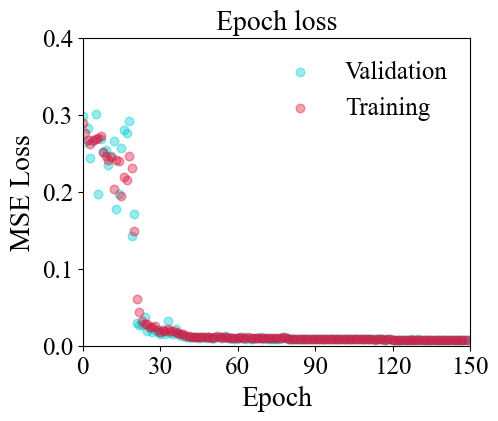

In [22]:
# Epoch_loss = np.loadtxt('./Result/uT_Loss.txt')
# valid_loss = Epoch_loss[:, 1]
# train_loss = Epoch_loss[:, 0]
epochs = 150

plt.rcParams['font.family'] = 'Times New Roman'
fig = plt.figure(facecolor='white', figsize=(5, 4))
plt.xlim(xmax=len(valid_loss), xmin=0)
x1 = [i for i in range(0, len(valid_loss))]
y1 = valid_loss
x2 = [i for i in range(0, len(train_loss))]
y2 = train_loss
colors1 = '#00CED4'
colors2 = '#DC143C'
area = np.pi*4**1.8
plt.scatter(x1, y1, s=area, c=colors1, alpha=0.4, label='Validation')
plt.scatter(x2, y2, s=area, c=colors2, alpha=0.4, label='Training')
plt.title('Epoch loss', fontsize=20)
plt.xlim(0, epochs)
plt.ylim(0, 0.4)
plt.xticks(np.arange(0, epochs+1, 30), fontsize=18)
plt.yticks(np.arange(0, 0.42, 0.1), fontsize=18)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('MSE Loss', fontsize=20)
plt.legend(frameon=False, loc='upper right', fontsize=18)
fig.savefig("./Result/uT_Loss.jpg", dpi=600, bbox_inches='tight', pad_inches=0.1)
plt.show()

In [ ]:
model = MyModel(input_size, hidden_size, num_layers, output_size, dropout_rate).to(device)
model.load_state_dict(torch.load('./Result/{}_Model.pth'.format(Name)))
model.eval()

C:\Users\Dell\AppData\Local\Temp\ipykernel_22508\3454407233.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs).float().to(device)
C:\Users\Dell\AppData\Local\Temp\ipykernel_22508\3454407233.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).float().to(device)


MSE =  0.008837698
MAE =  0.07126152
R2 Score =  0.969501819926938


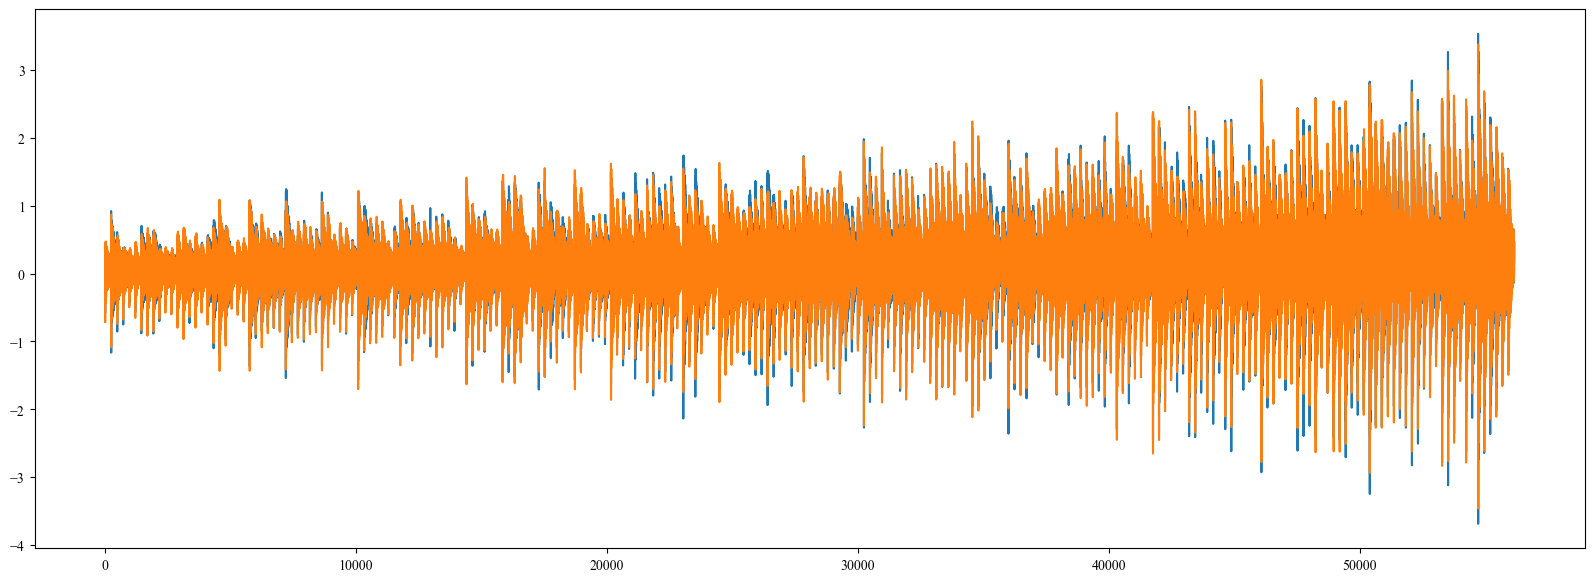

In [23]:
y_pred = []
y_true = []
with torch.no_grad():
    for inputs, targets in TestDataLoader:
        inputs = torch.tensor(inputs).float().to(device)
        targets = torch.tensor(targets).float().to(device)
        outputs = model(inputs)
        outputs = list(outputs.cpu().numpy().reshape([1, -1])[0])
        targets = list(targets.cpu().numpy().reshape([1, -1])[0])
        y_pred.extend(outputs)
        y_true.extend(targets)

Y = np.zeros((len(y_true), 2))
Y[:, 0] = np.array(y_true)
Y[:, 1] = np.array(y_pred)
np.savetxt('./Result/{}_testY.txt'.format(Name), Y, delimiter=' ')

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
Error_mse = mean_squared_error(y_pred, y_true)
Error_mae = mean_absolute_error(y_pred, y_true)
R2_Score = r2_score(y_pred, y_true)
print('MSE = ', Error_mse)
print('MAE = ', Error_mae)
print('R2 Score = ', R2_Score)

fig1 = plt.figure(facecolor='white', figsize=(20, 7))
len_ = [i for i in range(len(y_true))]
plt.plot(len_, y_true, label='y_true')
plt.plot(len_, y_pred, label='y_pred')
plt.show()

In [ ]:
fig2 = plt.figure(facecolor='white', figsize=(20, 7))
len_ = [i for i in range(len(y_true))]
plt.plot(len_[-240*3:], y_true[-240*3:], label='y_true')
plt.plot(len_[-240*3:], y_pred[-240*3:], label='y_pred')
plt.show()